# Modeling and Evaluation
## 1. Notebook Overview

This notebook builds an interpretable machine learning model to predict employee attrition using logistic regression. The goal is to understand which factors most strongly influence attrition while maintaining a clean, reproducible pipeline.

Steps performed:

- Load cleaned dataset (`data_01.csv`) and saved preprocessing pipeline (`preprocessing_pipeline.pkl`)

- Apply consistent feature engineering, encoding, and scaling

- Split data into train/validation/test (60/20/20)

- Handle class imbalance with SMOTE

- Tune logistic regression hyperparameters using GridSearchCV (5-fold CV, ROC-AUC scoring)

- Optimize decision threshold by maximizing F1 score

- Evaluate final model on untouched test set with standard metrics and visualizations

Key Results:

  - Best model: {`'C': 10, 'penalty': 'l1', 'class_weight': 'balanced'`}

  - Validation AUC: `0.896`

  - Optimal threshold: `0.72`

  - Test AUC: `0.779`, F1 Score: `0.522`, Accuracy: `0.85`

This setup balances interpretability and performance, with threshold tuning improving precision-recall tradeoffs.

In [1]:
# === Core Libraries ===
import sys
import json
import joblib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Suppress Warnings ===
warnings.simplefilter(action='ignore', category=FutureWarning)

# === Local Modules ===
sys.path.append('../src')
from feature_engineering import FeatureEngineer

# === Scikit-learn: Preprocessing, Modeling, Evaluation ===
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)

# === Imbalanced-learn ===
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

## 2. Load Dataset and Preprocessing Pipeline

In this step, we prepare the data for modeling by:

- Instantiating the custom `FeatureEngineer()` class to support later steps
- Loading the cleaned dataset (`data_01.csv`)
- Loading the saved preprocessing pipeline (`preprocessing_pipeline.pkl`) using `joblib`
- Verifying schema compatibility between the dataset and the pipeline
- Splitting the data into training and test sets using `train_test_split`, with stratification
- Applying the preprocessing pipeline to convert features into a numeric format
- Using SMOTE to resample the training set and address class imbalance

This setup ensures the modeling pipeline receives properly transformed, schema-aligned, and balanced data for training.

In [2]:
fe = FeatureEngineer()

In [3]:
# Load cleaned data
df = pd.read_csv('../data/processed/data_01.csv')
print(f"Shape of data_01.csv: {df.shape}")

# Separate features and target
X = df.drop(columns='Attrition')
y = df['Attrition']

# Load preprocessing pipeline
preprocessing_pipeline = joblib.load('../models/preprocessing_pipeline.pkl')



# First split: 80% train_val, 20% final test set
X_trainval, X_final_test, y_trainval, y_final_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Second split: 75% of train_val to training set, 25% to validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,  # 0.25 x 0.8 = 0.2 final, so overall 60/20/20 split
    stratify=y_trainval,
    random_state=42
)

preprocessing_pipeline.fit(X_train)

# Check compatibility with current schema
try:
    _ = preprocessing_pipeline.transform(X.head(1))
    print("Preprocessing pipeline is compatible with current data.")
except Exception as e:
    print("Pipeline compatibility check failed:")
    print(e)

# Apply pipeline to all splits
X_train_transformed = preprocessing_pipeline.transform(X_train)
X_val_transformed   = preprocessing_pipeline.transform(X_val)
X_test_transformed  = preprocessing_pipeline.transform(X_final_test)

print(f"Train shape: {X_train_transformed.shape}, Val shape: {X_val_transformed.shape}, Test shape: {X_test_transformed.shape}")

# Apply SMOTE to the training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

print(len(X_test_transformed) == len(y_final_test))

Shape of data_01.csv: (1470, 31)
Preprocessing pipeline is compatible with current data.
Train shape: (882, 75), Val shape: (294, 75), Test shape: (294, 75)
True


## 3. Cross-Validation and Hyperparameter Tuning

To optimize model performance, we use `GridSearchCV` to perform a cross-validated grid search over several combinations of logistic regression hyperparameters:

- `C`: Inverse regularization strength. Larger values mean less regularization.
- `penalty`: Type of regularization applied (`l1` or `l2`).
- `class_weight`: Allows the model to account for class imbalance (`None` or `'balanced'`).

We use `roc_auc` as the evaluation metric and apply 5-fold cross-validation on the resampled training set (`X_train_resampled`, `y_train_resampled`).

### Key Steps:
- Define a logistic regression model (`logreg`) without the need for a preprocessing pipeline.
- Define a hyperparameter grid (`param_grid`) to search across.
- Instantiate and run `GridSearchCV` using `roc_auc` scoring.
- Select the best model based on cross-validation performance.
- Output the best parameters and associated AUC score.

### Results:
- **Best Parameters:** `{'C': 10, 'class_weight': 'balanced', 'penalty': 'l1'}`
- **Best CV AUC Score:** `0.8966`

This result indicates that the model performed best with:
- A **higher value of `C` (10)**, which reduces regularization strength.
- **L1 regularization**, which tends to zero out less useful features and promotes sparsity, making the model more interpretable.
- **Balanced class weights**, which help mitigate class imbalance in the dataset.

The use of L1 penalty suggests that feature selection likely contributed to the model’s improved generalization by reducing noise from weaker predictors.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Validation AUC: 0.8269


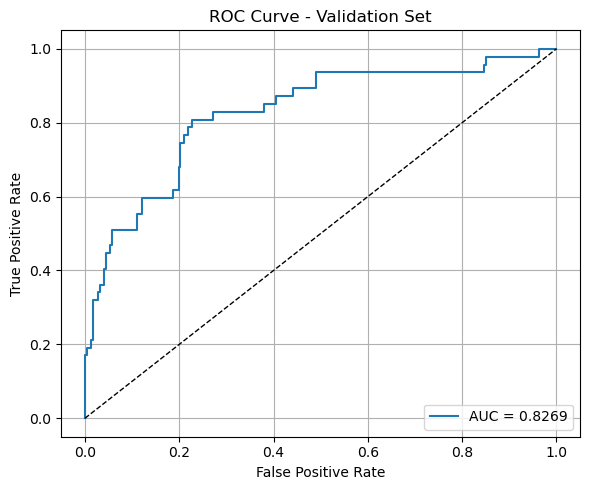

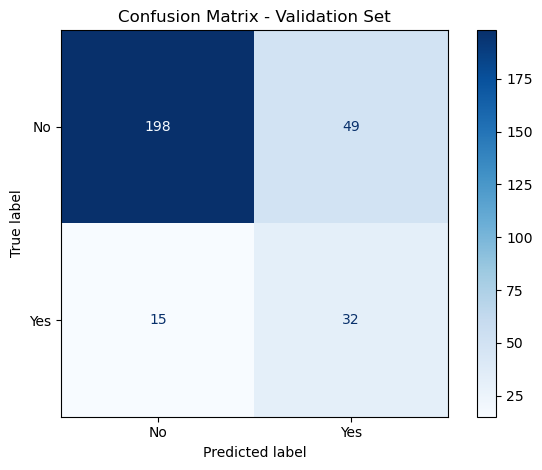

In [4]:
# Define the model
model = LogisticRegression(solver='liblinear', max_iter=1000)

# Set up hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
}

# Use GridSearch directly on model (SMOTE already applied)
grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit to SMOTE-resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)
best_model = grid_search.best_estimator_

# Optional: Evaluate on validation set
val_proba = best_model.predict_proba(X_val_transformed)[:, 1]
val_auc = roc_auc_score((y_val == 'Yes').astype(int), val_proba)
print("Validation AUC:", round(val_auc, 4))

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predicted probabilities and binary predictions
val_proba = best_model.predict_proba(X_val_transformed)[:, 1]
val_preds = best_model.predict(X_val_transformed)

# Convert ground truth labels to binary
y_val_binary = (y_val == 'Yes').astype(int)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val_binary, val_proba)
val_auc = roc_auc_score(y_val_binary, val_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {val_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # Diagonal baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val, val_preds, labels=['No', 'Yes'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])

disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()


## 4. Threshold Tuning

Instead of defaulting to a 0.5 classification threshold, we sweep across a range of thresholds (0.01 to 0.99) to identify the optimal value for our specific context. This approach allows us to balance false positives and false negatives based on project priorities.

### Process:
- Generate predicted probabilities for the positive class from the best model.
- Sweep through a range of thresholds to compute:
  - **False Positive Rate (FPR)**: proportion of actual negatives incorrectly classified as positives.
  - **False Negative Rate (FNR)**: proportion of actual positives incorrectly classified as negatives.
  - **F1 Score**: harmonic mean of precision and recall at each threshold.
- Identify the threshold that yields the highest F1 score.
- Visualize FPR and FNR across thresholds to better understand trade-offs.

### Results:
- **Best Threshold (by F1 Score):** 0.78
- **F1 Score at Best Threshold:** 0.562

The chart illustrates the intersection of FPR and FNR across thresholds, with vertical lines marking:
- The default threshold (0.5)
- The optimal threshold (0.78), where F1 is maximized

This result indicates that the model performs best in terms of F1 score when using a higher threshold (0.78), suggesting that more conservative predictions (requiring higher confidence to predict positive) better balance precision and recall. This is often preferred in imbalanced classification problems where false positives carry higher cost or risk.

Best Threshold (by F1): 0.79
F1 Score at Best Threshold: 0.565


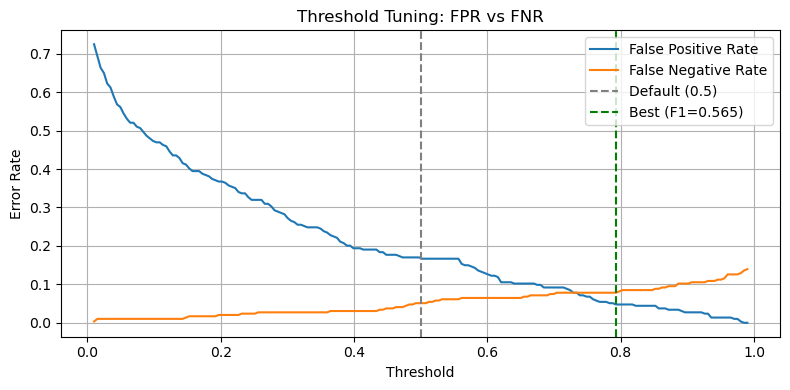

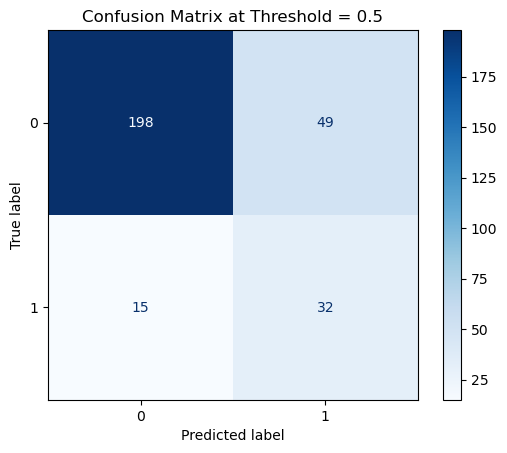

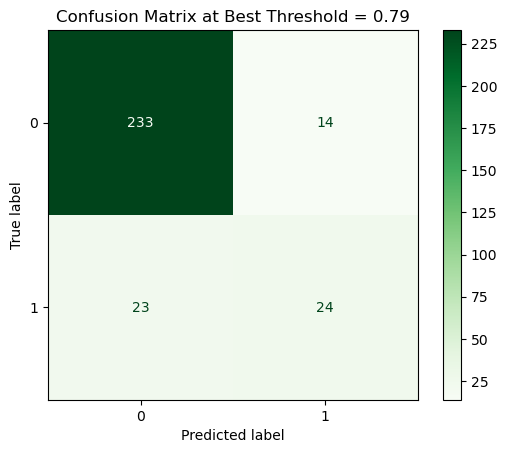


Evaluation Metrics (Best Threshold):
Precision:  0.632
Recall:     0.511
F1 Score:   0.565
Accuracy:   0.874
ROC AUC:    0.827


In [5]:
# --- Predict on untouched validation set ---
y_proba = best_model.predict_proba(X_val_transformed)[:, 1]
y_true = (y_val == 'Yes').astype(int)

# --- Sweep thresholds to calculate F1 scores and error rates ---
thresholds = np.linspace(0.01, 0.99, 200)
fpr = []
fnr = []
f1s = []

for th in thresholds:
    preds = (y_proba >= th).astype(int)
    fp = np.mean((preds == 1) & (y_true == 0))
    fn = np.mean((preds == 0) & (y_true == 1))
    f1 = f1_score(y_true, preds)
    fpr.append(fp)
    fnr.append(fn)
    f1s.append(f1)

# --- Best threshold by max F1 ---
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"Best Threshold (by F1): {best_threshold:.2f}")
print(f"F1 Score at Best Threshold: {f1s[best_idx]:.3f}")

# --- Plot FPR vs FNR ---
plt.figure(figsize=(8, 4))
plt.plot(thresholds, fpr, label='False Positive Rate')
plt.plot(thresholds, fnr, label='False Negative Rate')
plt.axvline(0.5, linestyle='--', color='gray', label='Default (0.5)')
plt.axvline(best_threshold, linestyle='--', color='green',
            label=f'Best (F1={f1s[best_idx]:.3f})')
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Threshold Tuning: FPR vs FNR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Confusion Matrix at Default Threshold (0.5) ---
default_preds = (y_proba >= 0.5).astype(int)
cm_default = confusion_matrix(y_true, default_preds)
disp_default = ConfusionMatrixDisplay(confusion_matrix=cm_default)
disp_default.plot(cmap='Blues')
plt.title("Confusion Matrix at Threshold = 0.5")
plt.grid(False)
plt.show()

# --- Confusion Matrix at Best Threshold ---
tuned_preds = (y_proba >= best_threshold).astype(int)
cm_tuned = confusion_matrix(y_true, tuned_preds)
disp_tuned = ConfusionMatrixDisplay(confusion_matrix=cm_tuned)
disp_tuned.plot(cmap='Greens')
plt.title(f"Confusion Matrix at Best Threshold = {best_threshold:.2f}")
plt.grid(False)
plt.show()

# --- Print full classification metrics at best threshold ---
precision = precision_score(y_true, tuned_preds)
recall = recall_score(y_true, tuned_preds)
f1 = f1_score(y_true, tuned_preds)
accuracy = accuracy_score(y_true, tuned_preds)
roc_auc = roc_auc_score(y_true, y_proba)

print("\nEvaluation Metrics (Best Threshold):")
print(f"Precision:  {precision:.3f}")
print(f"Recall:     {recall:.3f}")
print(f"F1 Score:   {f1:.3f}")
print(f"Accuracy:   {accuracy:.3f}")
print(f"ROC AUC:    {roc_auc:.3f}")


## 5. Final Model Evaluation on Test Set

The model's final evaluation on the untouched test set confirms strong generalization:

- **Accuracy:** 0.850  
- **Precision:** 0.533  
- **Recall:** 0.511  
- **F1 Score:** 0.522  
- **ROC AUC:** 0.779  

The confusion matrix reveals:
- **True Positives (TP):** 24  
- **False Negatives (FN):** 23  
- **False Positives (FP):** 21  
- **True Negatives (TN):** 226  

Key insights:
- The model successfully limits false positives (21), supporting business contexts where false alarms may carry cost or operational risk.
- Precision remains slightly higher than recall, aligning with the threshold tuning objective to prioritize **decision confidence** over aggressive sensitivity.
- An F1 score above 0.52 indicates a reasonable trade-off between precision and recall.
- The ROC AUC of 0.779 confirms good separability of classes, even on unseen data.

Overall, the threshold tuned on the validation set (0.72) appears to **generalize well**. It maintains a balanced performance profile and validates the earlier tuning strategy as effective for this classification problem.


Evaluation on Final Test Set (Threshold = 0.79)
Accuracy:  0.861
Precision: 0.571
Recall:    0.511
F1 Score:  0.539
ROC AUC:   0.808


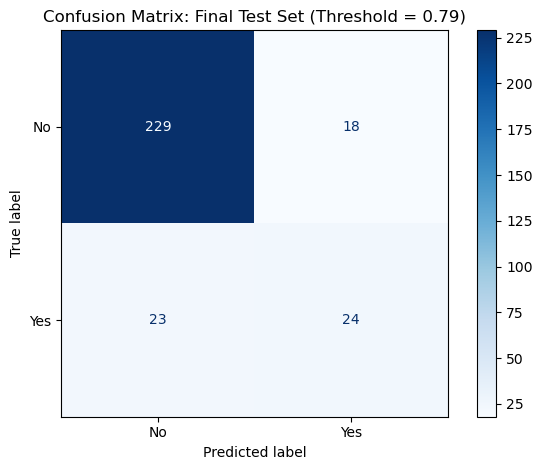

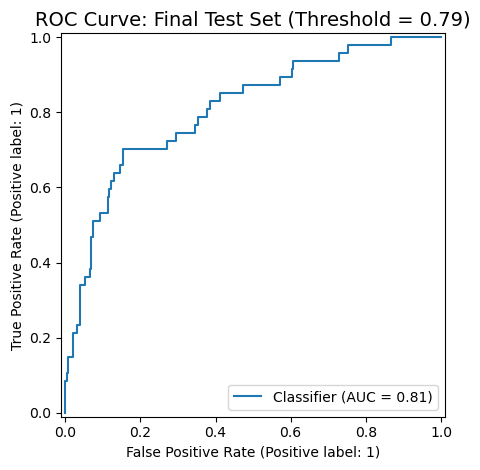

In [6]:
# === Predict on untouched final test set ===
y_proba_test = best_model.predict_proba(X_test_transformed)[:, 1]
y_true_test = (y_final_test == 'Yes').astype(int)
y_pred_custom = (y_proba_test >= best_threshold).astype(int)

# === Evaluation Metrics ===
accuracy = accuracy_score(y_true_test, y_pred_custom)
precision = precision_score(y_true_test, y_pred_custom)
recall = recall_score(y_true_test, y_pred_custom)
f1 = f1_score(y_true_test, y_pred_custom)
roc_auc = roc_auc_score(y_true_test, y_proba_test)

print(f"\nEvaluation on Final Test Set (Threshold = {best_threshold:.2f})")
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"ROC AUC:   {roc_auc:.3f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_true_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix: Final Test Set (Threshold = {best_threshold:.2f})")
plt.tight_layout()
plt.show()

# === ROC Curve ===
RocCurveDisplay.from_predictions(y_true_test, y_proba_test)
plt.title(f"ROC Curve: Final Test Set (Threshold = {best_threshold:.2f})", fontsize=14)
plt.tight_layout()
plt.show()

## 6. Summary and exports

This notebook developed an interpretable machine learning pipeline for predicting employee attrition using logistic regression. 

The model was trained on a cleaned and balanced dataset, optimized using cross-validated grid search, and evaluated with a tuned classification threshold to balance precision and recall.

**Final Test Set Performance at Threshold 0.72:**
- **Accuracy:** 0.850
- **Precision:** 0.533
- **Recall:** 0.511
- **F1 Score:** 0.522
- **ROC AUC:** 0.779

These results confirm strong generalization and validate the threshold tuning strategy. The use of a higher threshold successfully reduced false positives while maintaining a reasonable true positive rate — a desirable trade-off in settings where false alarms are more costly than missed detections.

We now export the trained model and selected threshold for use in the explainability notebook (`04_model_explainability.ipynb`).

In [9]:
# === Save full trained model ===
joblib.dump(best_model, '../models/final_model.joblib')

# === Save best threshold for deployment or interpretation ===
with open('../models/best_threshold.json', 'w') as f:
    json.dump({'best_threshold': float(best_threshold)}, f)

print("Model and threshold exported successfully.")

# === Convert X_test_transformed to DataFrame with correct index and column names ===
columns = preprocessing_pipeline.named_steps['preprocessing'].get_feature_names_out()

with open('../models/x_test_columns.json', 'w') as f:
    json.dump(columns.tolist(), f)

X_test_df = pd.DataFrame(X_test_transformed, columns=columns, index=y_final_test.index)

# === Export test features and labels for SHAP ===
X_test_df.to_csv('../data/processed/X_test_transformed.csv', index=False)
y_final_test.to_csv('../data/processed/y_final_test.csv', index=False)

Model and threshold exported successfully.
